# Model Selection

## 1 - Setup

### 1.1 - Load Modules/Libraries

In [1]:
import copy
import os
import sys

In [2]:
sys.path.insert(0, '/Users/joshua/Developer/civetqc')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import balanced_accuracy_score, classification_report, fbeta_score
from sklearn.model_selection import cross_val_score

In [5]:
from civetqc.data import CivetData, QCRatingsData
from civetqc.model import Model
from civetqc.train import f2_scorer, search

In [6]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

### 1.2 - Define Paths

In [7]:
ROOT_DIR = '/Users/joshua/Developer/civetqc'

In [8]:
DATA_DIR = os.path.join(ROOT_DIR, 'data')
FIGURES_DIR = os.path.join(ROOT_DIR, 'figures')
TABLES_DIR = os.path.join(ROOT_DIR, 'tables')

In [9]:
TRAINING_DATASET_PATH = os.path.join(DATA_DIR, 'processed', 'training_dataset.csv')
TESTING_DATASET_PATH = os.path.join(DATA_DIR, 'processed', 'testing_dataset.csv')

### 1.3 - Set Random Seed for Reproducibility

In [10]:
np.random.seed(0)

## 2 - Training

### 2.1 - Load Training Data

In [11]:
civet_data = CivetData.from_csv(TRAINING_DATASET_PATH)
qc_data = QCRatingsData.from_csv(TRAINING_DATASET_PATH)

### 2.2 - Run Search

In [12]:
search.fit(civet_data.features, qc_data.ratings)
search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('fs',
                 SelectPercentile(percentile=90,
                                  score_func=<function f_regression at 0x282328280>)),
                ('sampler', SMOTE()),
                ('clf',
                 SVC(C=1.7453271965593198, gamma=0.2574526615306137,
                     kernel='linear'))])

### 2.3 - Assess CV Results

In [13]:
formatted_results = {
    "Percentile Features": [],
    "Classifier": [],
    "C": [],
    "Gamma": [],
    "Kernel": []
}

results = pd.DataFrame(search.cv_results_).sort_values(f"rank_test_{getattr(search, 'refit')}")
for i in results.index[:10]:
    formatted_results["Percentile Features"].append(results.loc[i, 'param_fs__percentile'])
    formatted_results['Classifier'].append(str(results.loc[i, 'param_clf']).split('(')[0])
    formatted_results['C'].append(round(results.loc[i, 'param_clf__C'], 2))
    formatted_results['Gamma'].append(round(results.loc[i, 'param_clf__gamma'], 2))
    formatted_results['Kernel'].append(results.loc[i, 'param_clf__kernel'])
    for metric in getattr(search, 'scoring').keys():
        if metric.title() not in formatted_results:
            formatted_results[metric.title()] = []
        mean = round(results.loc[i, f"mean_test_{metric}"], 2)
        std = round(results.loc[i, f"std_test_{metric}"], 2)
        formatted_results[metric.title()].append(f"{mean} ± {std}")
formatted_results = pd.DataFrame(formatted_results)
formatted_results.to_csv(os.path.join(TABLES_DIR, 'search_results.csv'), index=False)

In [14]:
formatted_results

,Percentile Features,Classifier,C,Gamma,Kernel,Balanced_Accuracy,F2,Precision_Acceptable_Scans,Recall_Acceptable_Scans,Precision_Unacceptable_Scans,Recall_Unacceptable_Scans
0,90,SVC,1.75,0.26,linear,0.94 ± 0.05,0.81 ± 0.11,1.0 ± 0.0,0.98 ± 0.02,0.63 ± 0.2,0.89 ± 0.09
1,100,SVC,1.20,0.16,linear,0.93 ± 0.06,0.8 ± 0.11,1.0 ± 0.0,0.98 ± 0.02,0.7 ± 0.24,0.87 ± 0.12
2,90,SVC,2.19,0.08,linear,0.92 ± 0.06,0.79 ± 0.12,1.0 ± 0.0,0.98 ± 0.02,0.64 ± 0.21,0.87 ± 0.12
3,100,SVC,6.87,0.32,linear,0.92 ± 0.1,0.78 ± 0.18,0.99 ± 0.01,0.98 ± 0.02,0.68 ± 0.26,0.85 ± 0.19
4,100,SVC,1.34,0.43,linear,0.91 ± 0.07,0.78 ± 0.13,0.99 ± 0.01,0.98 ± 0.02,0.69 ± 0.25,0.84 ± 0.14
5,90,SVC,1.57,0.38,linear,0.92 ± 0.04,0.77 ± 0.06,1.0 ± 0.0,0.98 ± 0.01,0.61 ± 0.17,0.86 ± 0.07
6,90,SVC,6.49,0.19,linear,0.91 ± 0.08,0.77 ± 0.15,0.99 ± 0.01,0.98 ± 0.03,0.65 ± 0.27,0.84 ± 0.14
7,100,SVC,5.62,0.02,linear,0.9 ± 0.09,0.76 ± 0.16,0.99 ± 0.01,0.98 ± 0.02,0.69 ± 0.24,0.81 ± 0.17
8,90,SVC,2.30,0.31,linear,0.91 ± 0.07,0.76 ± 0.12,0.99 ± 0.0,0.98 ± 0.02,0.63 ± 0.2,0.83 ± 0.14
9,100,SVC,4.69,0.22,linear,0.9 ± 0.09,0.75 ± 0.15,0.99 ± 0.01,0.98 ± 0.02,0.68 ± 0.26,0.81 ± 0.17


## 3 - Subset Analyses

In [15]:
training_data = pd.read_csv(TRAINING_DATASET_PATH)

In [16]:
def get_subset(df: pd.DataFrame, group_label: str) -> tuple:
    subset_df = df[df['GROUP'] == group_label]
    return subset_df[CivetData.feature_names].to_numpy(), subset_df['QC'].to_numpy()

In [17]:
control_features, control_target = get_subset(training_data, 'Control')
patient_features, patient_target = get_subset(training_data, 'Patient')

In [18]:
clf = copy.deepcopy(search.best_estimator_)

In [30]:
clf.fit(control_features, control_target)
print(classification_report(patient_target, clf.predict(patient_features)))
print(f"F2 Score (A): {round(fbeta_score(patient_target, clf.predict(patient_features), beta=2, pos_label=0), 2)}")
print(f"F2 Score (U): {round(fbeta_score(patient_target, clf.predict(patient_features), beta=2, pos_label=1), 2)}")
print(f"Balanced Accuracy: {round(balanced_accuracy_score(patient_target, clf.predict(patient_features)), 2)}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       548
           1       1.00      0.47      0.64        17

    accuracy                           0.98       565
   macro avg       0.99      0.74      0.82       565
weighted avg       0.98      0.98      0.98       565

F2 Score (A): 1.0
F2 Score (U): 0.53
Balanced Accuracy: 0.74


In [31]:
clf.fit(patient_features, patient_target)
print(classification_report(control_target, clf.predict(control_features)))
print(f"F2 Score (A): {round(fbeta_score(control_target, clf.predict(control_features), beta=2, pos_label=0), 2)}")
print(f"F2 Score (U): {round(fbeta_score(control_target, clf.predict(control_features), beta=2, pos_label=1), 2)}")
print(f"Balanced Accuracy: {round(balanced_accuracy_score(control_target, clf.predict(control_features)), 2)}")

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       459
           1       0.29      0.80      0.42        10

    accuracy                           0.95       469
   macro avg       0.64      0.88      0.70       469
weighted avg       0.98      0.95      0.96       469

F2 Score (A): 0.96
F2 Score (U): 0.59
Balanced Accuracy: 0.88


## 4 - Feature Importance

In [21]:
result = permutation_importance(
    search.best_estimator_,
    civet_data.features,
    qc_data.ratings,
    scoring=f2_scorer,
    n_repeats=50
)

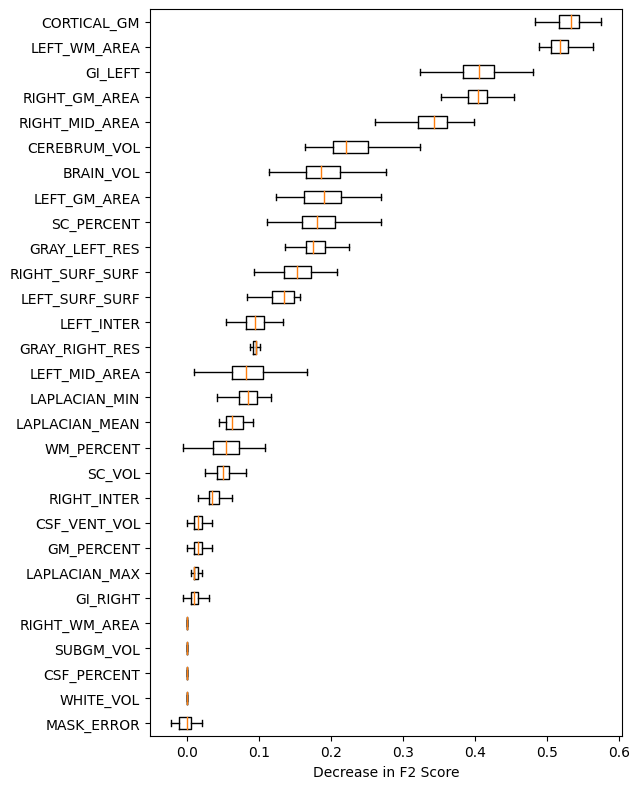

In [22]:
fig, ax = plt.subplots(figsize=[6.5, 8], tight_layout=True)
sorted_index = result.importances_mean.argsort()
sorted_names = civet_data.feature_names[sorted_index]
sorted_importances = result.importances[sorted_index].T
ax.boxplot(sorted_importances, vert=False, sym="")
ax.set_xlabel("Decrease in F2 Score")
ax.set_yticklabels(sorted_names)
plt.savefig(os.path.join(FIGURES_DIR, 'perm_importance.jpeg'), dpi=300)

In [23]:
importances_names = np.flip(civet_data.feature_names[sorted_index])
importances_values = np.flip(result.importances_mean[sorted_index])
for i in range(10):
    print(f"{importances_names[i]}: {importances_values[i]:.2f}")

CORTICAL_GM: 0.53
LEFT_WM_AREA: 0.52
GI_LEFT: 0.40
RIGHT_GM_AREA: 0.40
RIGHT_MID_AREA: 0.34
CEREBRUM_VOL: 0.23
BRAIN_VOL: 0.19
LEFT_GM_AREA: 0.19
SC_PERCENT: 0.18
GRAY_LEFT_RES: 0.18


## 4 - Testing

### 3.1 - Load Testing Data

In [24]:
testing_features = CivetData.from_csv(TESTING_DATASET_PATH).features
testing_target = QCRatingsData.from_csv(TESTING_DATASET_PATH).ratings

### 3.2 - Assess Performance

In [25]:
for i in range(2):
    print(round(fbeta_score(testing_target, search.predict(testing_features), beta=2, pos_label=i), 2))

0.95
0.95


In [26]:
round(balanced_accuracy_score(testing_target, search.predict(testing_features)), 2)

0.97

In [27]:
print(classification_report(testing_target, search.predict(testing_features)))

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        98
         1.0       0.79      1.00      0.88        22

    accuracy                           0.95       120
   macro avg       0.89      0.97      0.92       120
weighted avg       0.96      0.95      0.95       120

